In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import math
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [3]:
data = pd.read_csv("TripData_cleaned.csv")
data = data.drop('Unnamed: 0', axis=1)

data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Passenger_count,Trip_distance,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Total_amount,Trip_duration,Pickup_time,Speed,Pickup_cluster,Dropoff_cluster,year,month,day,time_span
0,2015-04-01 00:00:00,2015/4/1 0:08,1,3.08,-73.958817,40.716824,-73.982971,40.696007,14.76,8.0,1.427818e+09,23.100000,7,25,2015,4,1,0
1,2015-04-01 00:00:00,2015/4/1 0:07,1,1.21,-73.937531,40.804501,-73.946800,40.815998,8.30,7.0,1.427818e+09,10.371429,11,11,2015,4,1,0
2,2015-04-01 00:00:00,2015/4/1 0:02,1,0.64,-73.955818,40.681152,-73.955406,40.687145,6.00,2.0,1.427818e+09,19.200000,0,18,2015,4,1,0
3,2015-04-01 00:00:00,2015/4/1 0:05,1,1.34,-73.830551,40.759460,-73.825363,40.741589,7.80,5.0,1.427818e+09,16.080000,20,20,2015,4,1,0
4,2015-04-01 00:00:00,2015/4/1 0:05,1,0.98,-73.912086,40.775356,-73.915474,40.764091,7.30,5.0,1.427818e+09,11.760000,17,19,2015,4,1,0


In [4]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = data.groupby(['year', 'month', 'day', 'time_span', 'Pickup_cluster','Dropoff_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()
# 将列名 'time_span' 修改为 'hour'
grouped_data = grouped_data.rename(columns={'time_span': 'hour'})

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
grouped_data['Passenger_count'] = scaler.fit_transform(grouped_data[['Passenger_count']])

grouped_data.head()

,year,month,day,hour,Pickup_cluster,Dropoff_cluster,Passenger_count
0,2015,4,1,0,0,0,0.028261
1,2015,4,1,0,0,7,0.010870
2,2015,4,1,0,0,10,0.015217
3,2015,4,1,0,0,11,0.002174
4,2015,4,1,0,0,12,0.019565


In [5]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = grouped_data.groupby(['year', 'month', 'day', 'hour', 'Pickup_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()
# 将列名 'time_span' 修改为 'hour'
grouped_data = grouped_data.rename(columns={'time_span': 'hour'})

# 初始化 MinMaxScaler
scaler_reversed = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
grouped_data['Passenger_count'] = scaler_reversed.fit_transform(grouped_data[['Passenger_count']])

grouped_data.head()

,year,month,day,hour,Pickup_cluster,Passenger_count
0,2015,4,1,0,0,0.042034
1,2015,4,1,0,1,0.058983
2,2015,4,1,0,2,0.157966
3,2015,4,1,0,3,0.014237
4,2015,4,1,0,4,0.031186


In [6]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
data['Passenger_count'] = scaler.fit_transform(data[['Passenger_count']])

In [7]:
passenger_count = []
cluster_count = len(grouped_data['Pickup_cluster'].unique())
temp_count = [0]*cluster_count
last_index = -1

for i in range(len(grouped_data)):
    # 使用 int() 函数确保索引是整数
    current_index = int(grouped_data.iloc[i]['Pickup_cluster'])
    
    if current_index < last_index:
        passenger_count.append(temp_count)
        temp_count = [0] * cluster_count

    temp_count[current_index] = grouped_data.iloc[i]['Passenger_count']
    last_index = current_index

# 添加最后一个周期的数据
passenger_count.append(temp_count)
    
len(passenger_count[0])

30

In [8]:
passenger_count = np.array(passenger_count)
passenger_count

array([[0.0420339 , 0.05898305, 0.1579661 , ..., 0.00474576, 0.00610169,
        0.00542373],
       [0.0379661 , 0.02576271, 0.11661017, ..., 0.00067797, 0.00542373,
        0.00067797],
       [0.02372881, 0.01220339, 0.0820339 , ..., 0.00067797, 0.00135593,
        0.00067797],
       ...,
       [0.08474576, 0.26847458, 0.14169492, ..., 0.00745763, 0.01966102,
        0.01288136],
       [0.12745763, 0.23322034, 0.12271186, ..., 0.00949153, 0.01762712,
        0.01016949],
       [0.06711864, 0.13762712, 0.0820339 , ..., 0.00338983, 0.00949153,
        0.00677966]])

In [9]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

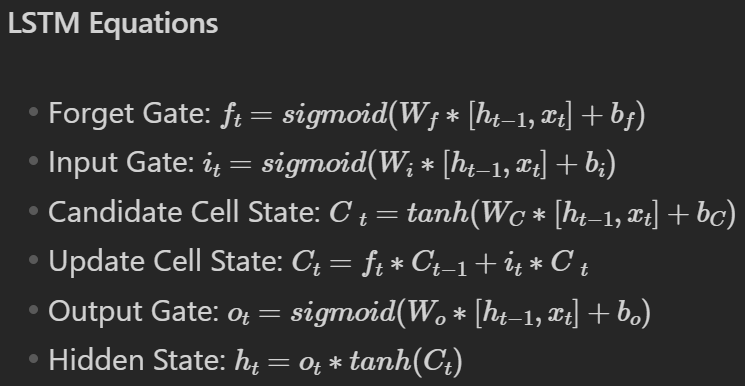
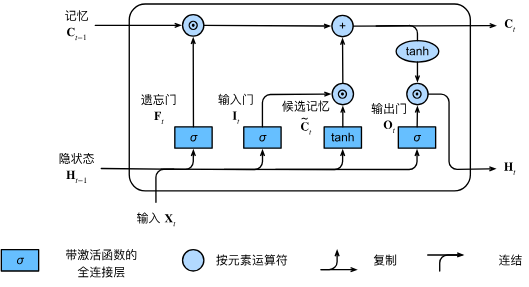

In [10]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [11]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [12]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 16, 
    'learning_rate': 1e-5,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/LSTM.ckpt'  # Your model will be saved here.
}

In [14]:
print(f"len(Passenger_count):{len(passenger_count)}")

len(Passenger_count):449


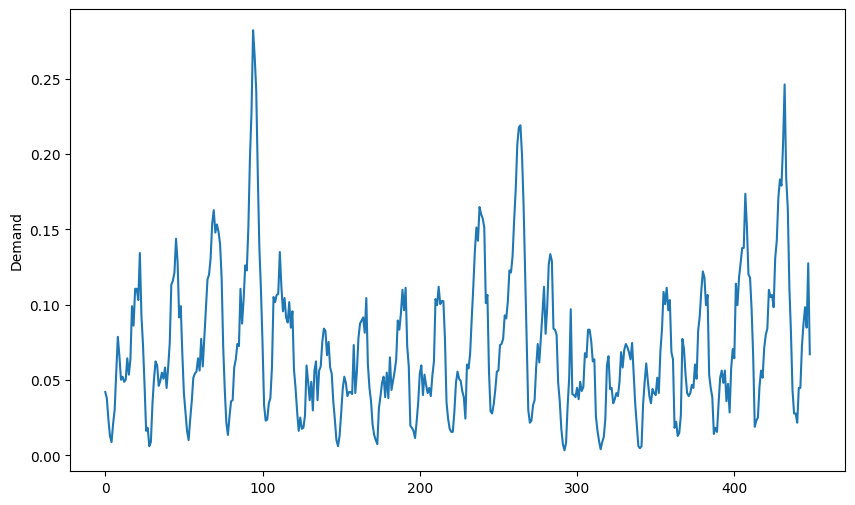

In [15]:
# 从每个周期中提取第一个簇的乘客计数
first_cluster_passenger_count = [cycle[0] for cycle in passenger_count]

# 设置图表大小
plt.figure(figsize=(10, 6))

# 绘制图表
plt.plot([i for i in range(len(first_cluster_passenger_count))], first_cluster_passenger_count)

# 设置y轴标签和字体大小
plt.ylabel("Demand", fontsize=10)

# 显示图表
plt.show()

In [16]:
def split_data(data,time_step=24):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [17]:
dataX,datay, dataNew=split_data(passenger_count)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(425, 24, 30),datay.shape:(425, 30),dataNew.shape:(425, 25, 30)


In [18]:
# 计算验证集的大小（后10%的数据）
valid_size = int(len(dataNew) * 0.1)

# 从数据集的末尾取后10%作为验证集
valid_data = dataNew[-valid_size:]

In [19]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

In [20]:
# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

number of features: 24


In [21]:
len(train_data)

340

In [22]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [23]:
# 定义输入、隐藏状态和输出维度
input_size = cluster_count  # 输入特征维度
hidden_size = 8  # LSTM隐藏状态维度
num_layers = 8  # LSTM层数
output_size = cluster_count  # 输出维度（预测目标维度）

In [24]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.18it/s, loss=0.0548]


Epoch [1/500]: Train loss: 0.0568, Test loss: 0.0555
Saving model with loss 0.055...


Epoch [2/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.92it/s, loss=0.0551]


Epoch [2/500]: Train loss: 0.0545, Test loss: 0.0544
Saving model with loss 0.054...


Epoch [3/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.08it/s, loss=0.0486]


Epoch [3/500]: Train loss: 0.0522, Test loss: 0.0510
Saving model with loss 0.051...


Epoch [4/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.16it/s, loss=0.0459]


Epoch [4/500]: Train loss: 0.0501, Test loss: 0.0509
Saving model with loss 0.051...


Epoch [5/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.02it/s, loss=0.0611]


Epoch [5/500]: Train loss: 0.0488, Test loss: 0.0478
Saving model with loss 0.048...


Epoch [6/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.15it/s, loss=0.0505]


Epoch [6/500]: Train loss: 0.0467, Test loss: 0.0463
Saving model with loss 0.046...


Epoch [7/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.87it/s, loss=0.0416]


Epoch [7/500]: Train loss: 0.0447, Test loss: 0.0435
Saving model with loss 0.044...


Epoch [8/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.05it/s, loss=0.0414]


Epoch [8/500]: Train loss: 0.0431, Test loss: 0.0426
Saving model with loss 0.043...


Epoch [9/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.60it/s, loss=0.0352]


Epoch [9/500]: Train loss: 0.0413, Test loss: 0.0410
Saving model with loss 0.041...


Epoch [10/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.86it/s, loss=0.0402]


Epoch [10/500]: Train loss: 0.0399, Test loss: 0.0398
Saving model with loss 0.040...


Epoch [11/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.73it/s, loss=0.0445]


Epoch [11/500]: Train loss: 0.0384, Test loss: 0.0372
Saving model with loss 0.037...


Epoch [12/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.10it/s, loss=0.0306]

Epoch [12/500]: Train loss: 0.0363, Test loss: 0.0361


Saving model with loss 0.036...


Epoch [13/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.38it/s, loss=0.0304]

Epoch [13/500]: Train loss: 0.0346, Test loss: 0.0342


Saving model with loss 0.034...


Epoch [14/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.84it/s, loss=0.0321]


Epoch [14/500]: Train loss: 0.0330, Test loss: 0.0315
Saving model with loss 0.032...


Epoch [15/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.30it/s, loss=0.0277]


Epoch [15/500]: Train loss: 0.0311, Test loss: 0.0303
Saving model with loss 0.030...


Epoch [16/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.12it/s, loss=0.0255]


Epoch [16/500]: Train loss: 0.0293, Test loss: 0.0286
Saving model with loss 0.029...


Epoch [17/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.97it/s, loss=0.0264]


Epoch [17/500]: Train loss: 0.0277, Test loss: 0.0269
Saving model with loss 0.027...


Epoch [18/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.22it/s, loss=0.0251]

Epoch [18/500]: Train loss: 0.0260, Test loss: 0.0251


Saving model with loss 0.025...


Epoch [19/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.13it/s, loss=0.0209]


Epoch [19/500]: Train loss: 0.0243, Test loss: 0.0239
Saving model with loss 0.024...


Epoch [20/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.07it/s, loss=0.0266]


Epoch [20/500]: Train loss: 0.0231, Test loss: 0.0228
Saving model with loss 0.023...


Epoch [21/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 104.11it/s, loss=0.0264]


Epoch [21/500]: Train loss: 0.0216, Test loss: 0.0207
Saving model with loss 0.021...


Epoch [22/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.28it/s, loss=0.0182]


Epoch [22/500]: Train loss: 0.0200, Test loss: 0.0201
Saving model with loss 0.020...


Epoch [23/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.04it/s, loss=0.0157]


Epoch [23/500]: Train loss: 0.0187, Test loss: 0.0184
Saving model with loss 0.018...


Epoch [24/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.77it/s, loss=0.0155]


Epoch [24/500]: Train loss: 0.0175, Test loss: 0.0168
Saving model with loss 0.017...


Epoch [25/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.40it/s, loss=0.0164]


Epoch [25/500]: Train loss: 0.0164, Test loss: 0.0159
Saving model with loss 0.016...


Epoch [26/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 87.03it/s, loss=0.0152]


Epoch [26/500]: Train loss: 0.0153, Test loss: 0.0147
Saving model with loss 0.015...


Epoch [27/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.23it/s, loss=0.0116]


Epoch [27/500]: Train loss: 0.0142, Test loss: 0.0138
Saving model with loss 0.014...


Epoch [28/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.35it/s, loss=0.0105]


Epoch [28/500]: Train loss: 0.0132, Test loss: 0.0130
Saving model with loss 0.013...


Epoch [29/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.39it/s, loss=0.0135]


Epoch [29/500]: Train loss: 0.0124, Test loss: 0.0120
Saving model with loss 0.012...


Epoch [30/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.10it/s, loss=0.0103]


Epoch [30/500]: Train loss: 0.0115, Test loss: 0.0111
Saving model with loss 0.011...


Epoch [31/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 95.51it/s, loss=0.00883]


Epoch [31/500]: Train loss: 0.0106, Test loss: 0.0102
Saving model with loss 0.010...


Epoch [32/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.14it/s, loss=0.00819]


Epoch [32/500]: Train loss: 0.0098, Test loss: 0.0095
Saving model with loss 0.009...


Epoch [33/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.74it/s, loss=0.00741]


Epoch [33/500]: Train loss: 0.0091, Test loss: 0.0090
Saving model with loss 0.009...


Epoch [34/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.63it/s, loss=0.00741]


Epoch [34/500]: Train loss: 0.0084, Test loss: 0.0086
Saving model with loss 0.009...


Epoch [35/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.75it/s, loss=0.011]


Epoch [35/500]: Train loss: 0.0079, Test loss: 0.0075
Saving model with loss 0.007...


Epoch [36/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.14it/s, loss=0.00858]


Epoch [36/500]: Train loss: 0.0073, Test loss: 0.0068
Saving model with loss 0.007...


Epoch [37/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 91.33it/s, loss=0.00421]


Epoch [37/500]: Train loss: 0.0067, Test loss: 0.0074


Epoch [38/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.20it/s, loss=0.00835]


Epoch [38/500]: Train loss: 0.0064, Test loss: 0.0061
Saving model with loss 0.006...


Epoch [39/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.27it/s, loss=0.00425]


Epoch [39/500]: Train loss: 0.0059, Test loss: 0.0056
Saving model with loss 0.006...


Epoch [40/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.56it/s, loss=0.00483]


Epoch [40/500]: Train loss: 0.0056, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [41/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.41it/s, loss=0.0031]


Epoch [41/500]: Train loss: 0.0052, Test loss: 0.0051
Saving model with loss 0.005...


Epoch [42/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.32it/s, loss=0.00642]


Epoch [42/500]: Train loss: 0.0051, Test loss: 0.0051
Saving model with loss 0.005...


Epoch [43/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.93it/s, loss=0.00455]


Epoch [43/500]: Train loss: 0.0048, Test loss: 0.0047
Saving model with loss 0.005...


Epoch [44/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.43it/s, loss=0.00187]


Epoch [44/500]: Train loss: 0.0046, Test loss: 0.0048


Epoch [45/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.26it/s, loss=0.00316]


Epoch [45/500]: Train loss: 0.0045, Test loss: 0.0043
Saving model with loss 0.004...


Epoch [46/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.51it/s, loss=0.00555]


Epoch [46/500]: Train loss: 0.0044, Test loss: 0.0044


Epoch [47/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.18it/s, loss=0.0031]


Epoch [47/500]: Train loss: 0.0043, Test loss: 0.0047


Epoch [48/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.96it/s, loss=0.00323]


Epoch [48/500]: Train loss: 0.0042, Test loss: 0.0047


Epoch [49/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.33it/s, loss=0.00162]


Epoch [49/500]: Train loss: 0.0041, Test loss: 0.0044


Epoch [50/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.08it/s, loss=0.00268]


Epoch [50/500]: Train loss: 0.0041, Test loss: 0.0043


Epoch [51/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.64it/s, loss=0.00836]


Epoch [51/500]: Train loss: 0.0042, Test loss: 0.0046


Epoch [52/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.10it/s, loss=0.00423]


Epoch [52/500]: Train loss: 0.0041, Test loss: 0.0040
Saving model with loss 0.004...


Epoch [53/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 83.36it/s, loss=0.00259]


Epoch [53/500]: Train loss: 0.0040, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [54/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.29it/s, loss=0.00341]


Epoch [54/500]: Train loss: 0.0040, Test loss: 0.0042


Epoch [55/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.43it/s, loss=0.00261]


Epoch [55/500]: Train loss: 0.0040, Test loss: 0.0040


Epoch [56/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.59it/s, loss=0.00754]


Epoch [56/500]: Train loss: 0.0041, Test loss: 0.0041


Epoch [57/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.08it/s, loss=0.00692]


Epoch [57/500]: Train loss: 0.0041, Test loss: 0.0040


Epoch [58/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.72it/s, loss=0.0031]


Epoch [58/500]: Train loss: 0.0040, Test loss: 0.0040


Epoch [59/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 97.14it/s, loss=0.00311]


Epoch [59/500]: Train loss: 0.0040, Test loss: 0.0043


Epoch [60/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.14it/s, loss=0.00228]


Epoch [60/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [61/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.91it/s, loss=0.0013]


Epoch [61/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [62/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.88it/s, loss=0.00123]


Epoch [62/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [63/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.14it/s, loss=0.00652]


Epoch [63/500]: Train loss: 0.0041, Test loss: 0.0046


Epoch [64/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.24it/s, loss=0.00244]


Epoch [64/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [65/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.62it/s, loss=0.00283]


Epoch [65/500]: Train loss: 0.0039, Test loss: 0.0043


Epoch [66/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.19it/s, loss=0.0022]


Epoch [66/500]: Train loss: 0.0039, Test loss: 0.0043


Epoch [67/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.22it/s, loss=0.003]


Epoch [67/500]: Train loss: 0.0039, Test loss: 0.0045


Epoch [68/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.81it/s, loss=0.00275]


Epoch [68/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [69/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.92it/s, loss=0.00329]


Epoch [69/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [70/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 102.96it/s, loss=0.00217]


Epoch [70/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [71/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.05it/s, loss=0.00326]


Epoch [71/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [72/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.78it/s, loss=0.00803]


Epoch [72/500]: Train loss: 0.0041, Test loss: 0.0042


Epoch [73/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.33it/s, loss=0.00232]


Epoch [73/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [74/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.61it/s, loss=0.0043]


Epoch [74/500]: Train loss: 0.0040, Test loss: 0.0046


Epoch [75/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.56it/s, loss=0.00894]


Epoch [75/500]: Train loss: 0.0041, Test loss: 0.0041


Epoch [76/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.91it/s, loss=0.00272]


Epoch [76/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [77/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.07it/s, loss=0.00131]

Epoch [77/500]: Train loss: 0.0039, Test loss: 0.0042

Epoch [78/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.64it/s, loss=0.00201]


Epoch [78/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [79/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.33it/s, loss=0.00663]


Epoch [79/500]: Train loss: 0.0041, Test loss: 0.0044


Epoch [80/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.02it/s, loss=0.00857]


Epoch [80/500]: Train loss: 0.0041, Test loss: 0.0040


Epoch [81/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.49it/s, loss=0.00212]


Epoch [81/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [82/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.75it/s, loss=0.00145]


Epoch [82/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [83/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.69it/s, loss=0.00488]


Epoch [83/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [84/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.68it/s, loss=0.00309]


Epoch [84/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [85/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.71it/s, loss=0.0019]


Epoch [85/500]: Train loss: 0.0039, Test loss: 0.0045


Epoch [86/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.89it/s, loss=0.00167]


Epoch [86/500]: Train loss: 0.0039, Test loss: 0.0045


Epoch [87/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.56it/s, loss=0.00151]


Epoch [87/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [88/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.80it/s, loss=0.00418]


Epoch [88/500]: Train loss: 0.0040, Test loss: 0.0039


Epoch [89/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.14it/s, loss=0.00632]


Epoch [89/500]: Train loss: 0.0041, Test loss: 0.0040


Epoch [90/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.46it/s, loss=0.00272]


Epoch [90/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [91/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 90.95it/s, loss=0.0074]


Epoch [91/500]: Train loss: 0.0041, Test loss: 0.0045


Epoch [92/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.82it/s, loss=0.0073]


Epoch [92/500]: Train loss: 0.0041, Test loss: 0.0039


Epoch [93/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.30it/s, loss=0.00193]


Epoch [93/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [94/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.18it/s, loss=0.00215]


Epoch [94/500]: Train loss: 0.0039, Test loss: 0.0046


Epoch [95/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.37it/s, loss=0.00342]


Epoch [95/500]: Train loss: 0.0040, Test loss: 0.0042


Epoch [96/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.42it/s, loss=0.00581]


Epoch [96/500]: Train loss: 0.0040, Test loss: 0.0046


Epoch [97/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 92.73it/s, loss=0.00761]


Epoch [97/500]: Train loss: 0.0041, Test loss: 0.0042


Epoch [98/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.44it/s, loss=0.00213]


Epoch [98/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [99/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.35it/s, loss=0.00275]


Epoch [99/500]: Train loss: 0.0039, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [100/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.64it/s, loss=0.00147]


Epoch [100/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [101/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.67it/s, loss=0.00244]


Epoch [101/500]: Train loss: 0.0039, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [102/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 87.69it/s, loss=0.00298]


Epoch [102/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [103/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.92it/s, loss=0.00247]


Epoch [103/500]: Train loss: 0.0039, Test loss: 0.0045


Epoch [104/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.03it/s, loss=0.0122]


Epoch [104/500]: Train loss: 0.0043, Test loss: 0.0046


Epoch [105/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.33it/s, loss=0.00224]


Epoch [105/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [106/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.54it/s, loss=0.00251]


Epoch [106/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [107/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 105.20it/s, loss=0.00187]


Epoch [107/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [108/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.38it/s, loss=0.00175]


Epoch [108/500]: Train loss: 0.0039, Test loss: 0.0043


Epoch [109/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.14it/s, loss=0.00415]


Epoch [109/500]: Train loss: 0.0040, Test loss: 0.0049


Epoch [110/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.02it/s, loss=0.00261]


Epoch [110/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [111/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.04it/s, loss=0.00665]


Epoch [111/500]: Train loss: 0.0041, Test loss: 0.0047


Epoch [112/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.14it/s, loss=0.00166]


Epoch [112/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [113/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 82.10it/s, loss=0.00303]


Epoch [113/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [114/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.48it/s, loss=0.0042]


Epoch [114/500]: Train loss: 0.0040, Test loss: 0.0040


Epoch [115/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.71it/s, loss=0.00403]


Epoch [115/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [116/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.42it/s, loss=0.0086]


Epoch [116/500]: Train loss: 0.0041, Test loss: 0.0040


Epoch [117/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.56it/s, loss=0.00721]


Epoch [117/500]: Train loss: 0.0041, Test loss: 0.0045


Epoch [118/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 102.98it/s, loss=0.00677]


Epoch [118/500]: Train loss: 0.0041, Test loss: 0.0042


Epoch [119/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.02it/s, loss=0.00385]


Epoch [119/500]: Train loss: 0.0040, Test loss: 0.0043


Epoch [120/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.99it/s, loss=0.00302]


Epoch [120/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [121/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.40it/s, loss=0.00217]


Epoch [121/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [122/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.81it/s, loss=0.00191]


Epoch [122/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [123/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.25it/s, loss=0.00406]


Epoch [123/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [124/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 91.52it/s, loss=0.00355]


Epoch [124/500]: Train loss: 0.0040, Test loss: 0.0043


Epoch [125/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.36it/s, loss=0.00406]


Epoch [125/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [126/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.77it/s, loss=0.0111]


Epoch [126/500]: Train loss: 0.0042, Test loss: 0.0039


Epoch [127/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.55it/s, loss=0.00201]


Epoch [127/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [128/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.07it/s, loss=0.00292]


Epoch [128/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [129/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 90.40it/s, loss=0.00245]


Epoch [129/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [130/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.24it/s, loss=0.00238]


Epoch [130/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [131/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.08it/s, loss=0.00395]


Epoch [131/500]: Train loss: 0.0040, Test loss: 0.0044


Epoch [132/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.65it/s, loss=0.00341]


Epoch [132/500]: Train loss: 0.0040, Test loss: 0.0044


Epoch [133/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.60it/s, loss=0.00206]


Epoch [133/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [134/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.44it/s, loss=0.00179]


Epoch [134/500]: Train loss: 0.0039, Test loss: 0.0047


Epoch [135/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 88.95it/s, loss=0.00308]


Epoch [135/500]: Train loss: 0.0039, Test loss: 0.0043


Epoch [136/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.95it/s, loss=0.00824]


Epoch [136/500]: Train loss: 0.0041, Test loss: 0.0039


Epoch [137/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.88it/s, loss=0.00207]


Epoch [137/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [138/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.37it/s, loss=0.00189]


Epoch [138/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [139/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.12it/s, loss=0.00118]


Epoch [139/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [140/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.28it/s, loss=0.00336]


Epoch [140/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [141/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.17it/s, loss=0.00622]


Epoch [141/500]: Train loss: 0.0040, Test loss: 0.0046


Epoch [142/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.79it/s, loss=0.00277]

Epoch [142/500]: Train loss: 0.0039, Test loss: 0.0040

Epoch [143/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.56it/s, loss=0.0023]


Epoch [143/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [144/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.53it/s, loss=0.00798]


Epoch [144/500]: Train loss: 0.0041, Test loss: 0.0041


Epoch [145/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 102.25it/s, loss=0.00283]


Epoch [145/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [146/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.19it/s, loss=0.00343]


Epoch [146/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [147/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.19it/s, loss=0.00176]


Epoch [147/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [148/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.16it/s, loss=0.00173]


Epoch [148/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [149/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.94it/s, loss=0.0083]


Epoch [149/500]: Train loss: 0.0041, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [150/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.56it/s, loss=0.00347]


Epoch [150/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [151/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 83.41it/s, loss=0.00265]


Epoch [151/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [152/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.87it/s, loss=0.00276]


Epoch [152/500]: Train loss: 0.0039, Test loss: 0.0043


Epoch [153/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.98it/s, loss=0.00422]


Epoch [153/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [154/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.77it/s, loss=0.00755]


Epoch [154/500]: Train loss: 0.0041, Test loss: 0.0044


Epoch [155/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.55it/s, loss=0.0016]


Epoch [155/500]: Train loss: 0.0039, Test loss: 0.0047


Epoch [156/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.74it/s, loss=0.00621]


Epoch [156/500]: Train loss: 0.0040, Test loss: 0.0043


Epoch [157/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.90it/s, loss=0.0116]


Epoch [157/500]: Train loss: 0.0042, Test loss: 0.0039


Epoch [158/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.37it/s, loss=0.00903]


Epoch [158/500]: Train loss: 0.0041, Test loss: 0.0041


Epoch [159/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.40it/s, loss=0.00469]


Epoch [159/500]: Train loss: 0.0040, Test loss: 0.0040


Epoch [160/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.56it/s, loss=0.0092]


Epoch [160/500]: Train loss: 0.0041, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [161/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.03it/s, loss=0.0025]


Epoch [161/500]: Train loss: 0.0039, Test loss: 0.0045


Epoch [162/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 92.87it/s, loss=0.00345]


Epoch [162/500]: Train loss: 0.0039, Test loss: 0.0038


Epoch [163/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.20it/s, loss=0.00178]


Epoch [163/500]: Train loss: 0.0038, Test loss: 0.0038


Epoch [164/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.06it/s, loss=0.0024]


Epoch [164/500]: Train loss: 0.0038, Test loss: 0.0040


Epoch [165/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.96it/s, loss=0.00353]


Epoch [165/500]: Train loss: 0.0038, Test loss: 0.0038


Epoch [166/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.65it/s, loss=0.00316]


Epoch [166/500]: Train loss: 0.0038, Test loss: 0.0039


Epoch [167/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.21it/s, loss=0.0033]


Epoch [167/500]: Train loss: 0.0038, Test loss: 0.0038


Epoch [168/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.40it/s, loss=0.00491]


Epoch [168/500]: Train loss: 0.0038, Test loss: 0.0037
Saving model with loss 0.004...


Epoch [169/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.03it/s, loss=0.0016]


Epoch [169/500]: Train loss: 0.0037, Test loss: 0.0041


Epoch [170/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.80it/s, loss=0.00452]


Epoch [170/500]: Train loss: 0.0038, Test loss: 0.0036
Saving model with loss 0.004...


Epoch [171/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.78it/s, loss=0.00294]


Epoch [171/500]: Train loss: 0.0037, Test loss: 0.0039


Epoch [172/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.91it/s, loss=0.00435]


Epoch [172/500]: Train loss: 0.0037, Test loss: 0.0037


Epoch [173/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.42it/s, loss=0.00586]


Epoch [173/500]: Train loss: 0.0038, Test loss: 0.0038


Epoch [174/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.93it/s, loss=0.00213]


Epoch [174/500]: Train loss: 0.0036, Test loss: 0.0038


Epoch [175/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.98it/s, loss=0.00405]


Epoch [175/500]: Train loss: 0.0037, Test loss: 0.0039


Epoch [176/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.93it/s, loss=0.00847]


Epoch [176/500]: Train loss: 0.0038, Test loss: 0.0042


Epoch [177/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 104.27it/s, loss=0.00782]


Epoch [177/500]: Train loss: 0.0038, Test loss: 0.0039


Epoch [178/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.98it/s, loss=0.00234]


Epoch [178/500]: Train loss: 0.0036, Test loss: 0.0040


Epoch [179/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.70it/s, loss=0.00154]


Epoch [179/500]: Train loss: 0.0036, Test loss: 0.0036


Epoch [180/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.36it/s, loss=0.0041]


Epoch [180/500]: Train loss: 0.0036, Test loss: 0.0038


Epoch [181/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.57it/s, loss=0.00318]


Epoch [181/500]: Train loss: 0.0036, Test loss: 0.0036


Epoch [182/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.94it/s, loss=0.00634]


Epoch [182/500]: Train loss: 0.0037, Test loss: 0.0039


Epoch [183/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 90.47it/s, loss=0.00314]


Epoch [183/500]: Train loss: 0.0036, Test loss: 0.0034
Saving model with loss 0.003...


Epoch [184/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.09it/s, loss=0.00754]


Epoch [184/500]: Train loss: 0.0037, Test loss: 0.0036


Epoch [185/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.76it/s, loss=0.00728]


Epoch [185/500]: Train loss: 0.0037, Test loss: 0.0040


Epoch [186/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.58it/s, loss=0.00203]


Epoch [186/500]: Train loss: 0.0035, Test loss: 0.0040


Epoch [187/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.66it/s, loss=0.00167]


Epoch [187/500]: Train loss: 0.0035, Test loss: 0.0037


Epoch [188/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.47it/s, loss=0.00537]


Epoch [188/500]: Train loss: 0.0036, Test loss: 0.0037


Epoch [189/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.72it/s, loss=0.00132]


Epoch [189/500]: Train loss: 0.0034, Test loss: 0.0035


Epoch [190/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.47it/s, loss=0.00438]


Epoch [190/500]: Train loss: 0.0035, Test loss: 0.0035


Epoch [191/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.88it/s, loss=0.00908]


Epoch [191/500]: Train loss: 0.0037, Test loss: 0.0035


Epoch [192/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.25it/s, loss=0.00323]


Epoch [192/500]: Train loss: 0.0035, Test loss: 0.0037


Epoch [193/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.49it/s, loss=0.00152]

Epoch [193/500]: Train loss: 0.0034, Test loss: 0.0040



Epoch [194/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.90it/s, loss=0.0034]


Epoch [194/500]: Train loss: 0.0034, Test loss: 0.0036


Epoch [195/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.07it/s, loss=0.0022]


Epoch [195/500]: Train loss: 0.0034, Test loss: 0.0037


Epoch [196/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.48it/s, loss=0.00281]


Epoch [196/500]: Train loss: 0.0034, Test loss: 0.0037


Epoch [197/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.58it/s, loss=0.00304]


Epoch [197/500]: Train loss: 0.0034, Test loss: 0.0035


Epoch [198/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.35it/s, loss=0.00642]


Epoch [198/500]: Train loss: 0.0035, Test loss: 0.0036


Epoch [199/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.41it/s, loss=0.00136]


Epoch [199/500]: Train loss: 0.0033, Test loss: 0.0033
Saving model with loss 0.003...


Epoch [200/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.65it/s, loss=0.002]


Epoch [200/500]: Train loss: 0.0033, Test loss: 0.0033
Saving model with loss 0.003...


Epoch [201/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.19it/s, loss=0.00214]


Epoch [201/500]: Train loss: 0.0033, Test loss: 0.0033


Epoch [202/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.96it/s, loss=0.00149]


Epoch [202/500]: Train loss: 0.0033, Test loss: 0.0037


Epoch [203/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.75it/s, loss=0.00177]

Epoch [203/500]: Train loss: 0.0033, Test loss: 0.0033



Epoch [204/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.22it/s, loss=0.00221]


Epoch [204/500]: Train loss: 0.0033, Test loss: 0.0034


Epoch [205/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.07it/s, loss=0.00636]


Epoch [205/500]: Train loss: 0.0034, Test loss: 0.0034


Epoch [206/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.18it/s, loss=0.00161]


Epoch [206/500]: Train loss: 0.0033, Test loss: 0.0036


Epoch [207/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.25it/s, loss=0.00236]


Epoch [207/500]: Train loss: 0.0033, Test loss: 0.0033


Epoch [208/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.48it/s, loss=0.00198]


Epoch [208/500]: Train loss: 0.0033, Test loss: 0.0034


Epoch [209/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.64it/s, loss=0.00549]


Epoch [209/500]: Train loss: 0.0034, Test loss: 0.0034


Epoch [210/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.93it/s, loss=0.0041]


Epoch [210/500]: Train loss: 0.0033, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [211/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.84it/s, loss=0.00704]


Epoch [211/500]: Train loss: 0.0034, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [212/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.82it/s, loss=0.00262]


Epoch [212/500]: Train loss: 0.0032, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [213/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.82it/s, loss=0.00588]


Epoch [213/500]: Train loss: 0.0033, Test loss: 0.0032


Epoch [214/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.83it/s, loss=0.00173]


Epoch [214/500]: Train loss: 0.0032, Test loss: 0.0034


Epoch [215/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.80it/s, loss=0.00461]


Epoch [215/500]: Train loss: 0.0033, Test loss: 0.0036


Epoch [216/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 98.69it/s, loss=0.0021]


Epoch [216/500]: Train loss: 0.0032, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [217/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.48it/s, loss=0.00192]


Epoch [217/500]: Train loss: 0.0032, Test loss: 0.0035


Epoch [218/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.32it/s, loss=0.00216]


Epoch [218/500]: Train loss: 0.0032, Test loss: 0.0033


Epoch [219/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.18it/s, loss=0.00164]


Epoch [219/500]: Train loss: 0.0031, Test loss: 0.0033


Epoch [220/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.62it/s, loss=0.00504]


Epoch [220/500]: Train loss: 0.0032, Test loss: 0.0036


Epoch [221/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.97it/s, loss=0.00421]


Epoch [221/500]: Train loss: 0.0032, Test loss: 0.0031
Saving model with loss 0.003...


Epoch [222/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.35it/s, loss=0.00185]


Epoch [222/500]: Train loss: 0.0031, Test loss: 0.0031


Epoch [223/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.36it/s, loss=0.00316]


Epoch [223/500]: Train loss: 0.0032, Test loss: 0.0032


Epoch [224/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.63it/s, loss=0.00441]


Epoch [224/500]: Train loss: 0.0032, Test loss: 0.0030
Saving model with loss 0.003...


Epoch [225/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.55it/s, loss=0.00219]


Epoch [225/500]: Train loss: 0.0031, Test loss: 0.0030
Saving model with loss 0.003...


Epoch [226/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 93.73it/s, loss=0.00163]


Epoch [226/500]: Train loss: 0.0031, Test loss: 0.0031


Epoch [227/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.60it/s, loss=0.00213]


Epoch [227/500]: Train loss: 0.0031, Test loss: 0.0031


Epoch [228/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.28it/s, loss=0.00382]


Epoch [228/500]: Train loss: 0.0031, Test loss: 0.0031


Epoch [229/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.34it/s, loss=0.00217]


Epoch [229/500]: Train loss: 0.0031, Test loss: 0.0030
Saving model with loss 0.003...


Epoch [230/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.80it/s, loss=0.00213]


Epoch [230/500]: Train loss: 0.0031, Test loss: 0.0030


Epoch [231/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.52it/s, loss=0.00667]


Epoch [231/500]: Train loss: 0.0032, Test loss: 0.0030


Epoch [232/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.08it/s, loss=0.00322]


Epoch [232/500]: Train loss: 0.0031, Test loss: 0.0029
Saving model with loss 0.003...


Epoch [233/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.83it/s, loss=0.00629]


Epoch [233/500]: Train loss: 0.0032, Test loss: 0.0029


Epoch [234/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.83it/s, loss=0.00207]


Epoch [234/500]: Train loss: 0.0030, Test loss: 0.0030


Epoch [235/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.62it/s, loss=0.00516]


Epoch [235/500]: Train loss: 0.0031, Test loss: 0.0033


Epoch [236/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.46it/s, loss=0.00433]


Epoch [236/500]: Train loss: 0.0031, Test loss: 0.0030


Epoch [237/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 87.40it/s, loss=0.00171]


Epoch [237/500]: Train loss: 0.0030, Test loss: 0.0032


Epoch [238/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.97it/s, loss=0.00486]


Epoch [238/500]: Train loss: 0.0031, Test loss: 0.0030


Epoch [239/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.59it/s, loss=0.00196]

Epoch [239/500]: Train loss: 0.0030, Test loss: 0.0031

Epoch [240/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.59it/s, loss=0.00182]


Epoch [240/500]: Train loss: 0.0030, Test loss: 0.0031


Epoch [241/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.20it/s, loss=0.00559]


Epoch [241/500]: Train loss: 0.0031, Test loss: 0.0033


Epoch [242/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 82.29it/s, loss=0.00195]


Epoch [242/500]: Train loss: 0.0030, Test loss: 0.0032


Epoch [243/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.14it/s, loss=0.00154]


Epoch [243/500]: Train loss: 0.0029, Test loss: 0.0029
Saving model with loss 0.003...


Epoch [244/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.22it/s, loss=0.00171]


Epoch [244/500]: Train loss: 0.0030, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [245/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.05it/s, loss=0.00176]


Epoch [245/500]: Train loss: 0.0029, Test loss: 0.0034


Epoch [246/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.98it/s, loss=0.0075]


Epoch [246/500]: Train loss: 0.0031, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [247/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 98.17it/s, loss=0.00192]


Epoch [247/500]: Train loss: 0.0029, Test loss: 0.0029


Epoch [248/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 102.88it/s, loss=0.00228]


Epoch [248/500]: Train loss: 0.0029, Test loss: 0.0028


Epoch [249/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.88it/s, loss=0.00211]


Epoch [249/500]: Train loss: 0.0029, Test loss: 0.0028


Epoch [250/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.47it/s, loss=0.00779]


Epoch [250/500]: Train loss: 0.0031, Test loss: 0.0028


Epoch [251/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.45it/s, loss=0.00559]


Epoch [251/500]: Train loss: 0.0030, Test loss: 0.0029


Epoch [252/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.16it/s, loss=0.00141]


Epoch [252/500]: Train loss: 0.0029, Test loss: 0.0029


Epoch [253/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.65it/s, loss=0.00138]


Epoch [253/500]: Train loss: 0.0029, Test loss: 0.0028


Epoch [254/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.23it/s, loss=0.00246]


Epoch [254/500]: Train loss: 0.0029, Test loss: 0.0028


Epoch [255/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.39it/s, loss=0.00198]


Epoch [255/500]: Train loss: 0.0029, Test loss: 0.0029


Epoch [256/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.91it/s, loss=0.00351]


Epoch [256/500]: Train loss: 0.0029, Test loss: 0.0029


Epoch [257/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.25it/s, loss=0.00142]


Epoch [257/500]: Train loss: 0.0028, Test loss: 0.0031


Epoch [258/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.40it/s, loss=0.00345]


Epoch [258/500]: Train loss: 0.0029, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [259/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.39it/s, loss=0.00704]


Epoch [259/500]: Train loss: 0.0030, Test loss: 0.0032


Epoch [260/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.07it/s, loss=0.00155]


Epoch [260/500]: Train loss: 0.0028, Test loss: 0.0028


Epoch [261/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.37it/s, loss=0.00181]


Epoch [261/500]: Train loss: 0.0028, Test loss: 0.0028


Epoch [262/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.15it/s, loss=0.00142]


Epoch [262/500]: Train loss: 0.0028, Test loss: 0.0036


Epoch [263/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.28it/s, loss=0.00211]


Epoch [263/500]: Train loss: 0.0028, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [264/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 93.15it/s, loss=0.00129]


Epoch [264/500]: Train loss: 0.0028, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [265/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.80it/s, loss=0.00549]


Epoch [265/500]: Train loss: 0.0029, Test loss: 0.0027
Saving model with loss 0.003...


Epoch [266/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.32it/s, loss=0.00224]


Epoch [266/500]: Train loss: 0.0028, Test loss: 0.0031


Epoch [267/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.68it/s, loss=0.0023]


Epoch [267/500]: Train loss: 0.0028, Test loss: 0.0027


Epoch [268/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.78it/s, loss=0.00178]


Epoch [268/500]: Train loss: 0.0028, Test loss: 0.0031


Epoch [269/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 82.82it/s, loss=0.0093]


Epoch [269/500]: Train loss: 0.0030, Test loss: 0.0031


Epoch [270/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.93it/s, loss=0.00714]


Epoch [270/500]: Train loss: 0.0030, Test loss: 0.0032


Epoch [271/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.02it/s, loss=0.00217]


Epoch [271/500]: Train loss: 0.0028, Test loss: 0.0027
Saving model with loss 0.003...


Epoch [272/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.17it/s, loss=0.00161]


Epoch [272/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [273/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.60it/s, loss=0.0016]


Epoch [273/500]: Train loss: 0.0027, Test loss: 0.0031


Epoch [274/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 83.58it/s, loss=0.00374]


Epoch [274/500]: Train loss: 0.0028, Test loss: 0.0026
Saving model with loss 0.003...


Epoch [275/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.42it/s, loss=0.00189]


Epoch [275/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [276/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.51it/s, loss=0.0026]


Epoch [276/500]: Train loss: 0.0027, Test loss: 0.0031


Epoch [277/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.36it/s, loss=0.000957]


Epoch [277/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [278/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.81it/s, loss=0.00222]


Epoch [278/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [279/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.01it/s, loss=0.00534]


Epoch [279/500]: Train loss: 0.0028, Test loss: 0.0027


Epoch [280/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.72it/s, loss=0.00178]


Epoch [280/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [281/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.23it/s, loss=0.00683]


Epoch [281/500]: Train loss: 0.0029, Test loss: 0.0026
Saving model with loss 0.003...


Epoch [282/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.65it/s, loss=0.0034]


Epoch [282/500]: Train loss: 0.0027, Test loss: 0.0028


Epoch [283/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.21it/s, loss=0.00223]


Epoch [283/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [284/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.75it/s, loss=0.00122]

Epoch [284/500]: Train loss: 0.0026, Test loss: 0.0025


Saving model with loss 0.003...


Epoch [285/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.30it/s, loss=0.00385]


Epoch [285/500]: Train loss: 0.0027, Test loss: 0.0025
Saving model with loss 0.003...


Epoch [286/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.48it/s, loss=0.00309]


Epoch [286/500]: Train loss: 0.0027, Test loss: 0.0026


Epoch [287/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.45it/s, loss=0.00472]


Epoch [287/500]: Train loss: 0.0028, Test loss: 0.0025


Epoch [288/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.17it/s, loss=0.00122]


Epoch [288/500]: Train loss: 0.0026, Test loss: 0.0025
Saving model with loss 0.002...


Epoch [289/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.72it/s, loss=0.00465]


Epoch [289/500]: Train loss: 0.0027, Test loss: 0.0026


Epoch [290/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.45it/s, loss=0.00169]


Epoch [290/500]: Train loss: 0.0026, Test loss: 0.0033


Epoch [291/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.17it/s, loss=0.000994]


Epoch [291/500]: Train loss: 0.0026, Test loss: 0.0026


Epoch [292/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.89it/s, loss=0.00104]


Epoch [292/500]: Train loss: 0.0026, Test loss: 0.0026


Epoch [293/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.00it/s, loss=0.00232]


Epoch [293/500]: Train loss: 0.0026, Test loss: 0.0027


Epoch [294/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.45it/s, loss=0.0032]


Epoch [294/500]: Train loss: 0.0027, Test loss: 0.0026


Epoch [295/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 91.70it/s, loss=0.00172]


Epoch [295/500]: Train loss: 0.0026, Test loss: 0.0026


Epoch [296/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.66it/s, loss=0.00384]


Epoch [296/500]: Train loss: 0.0027, Test loss: 0.0025
Saving model with loss 0.002...


Epoch [297/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.91it/s, loss=0.00134]


Epoch [297/500]: Train loss: 0.0026, Test loss: 0.0025


Epoch [298/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.63it/s, loss=0.00537]


Epoch [298/500]: Train loss: 0.0027, Test loss: 0.0026


Epoch [299/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.84it/s, loss=0.00111]


Epoch [299/500]: Train loss: 0.0026, Test loss: 0.0028


Epoch [300/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.49it/s, loss=0.00619]


Epoch [300/500]: Train loss: 0.0027, Test loss: 0.0029


Epoch [301/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.20it/s, loss=0.0107]


Epoch [301/500]: Train loss: 0.0029, Test loss: 0.0025


Epoch [302/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.94it/s, loss=0.00173]


Epoch [302/500]: Train loss: 0.0026, Test loss: 0.0025


Epoch [303/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.02it/s, loss=0.00103]


Epoch [303/500]: Train loss: 0.0025, Test loss: 0.0026


Epoch [304/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.00it/s, loss=0.00697]


Epoch [304/500]: Train loss: 0.0027, Test loss: 0.0029


Epoch [305/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.59it/s, loss=0.0031]


Epoch [305/500]: Train loss: 0.0026, Test loss: 0.0026


Epoch [306/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.61it/s, loss=0.00484]


Epoch [306/500]: Train loss: 0.0027, Test loss: 0.0024
Saving model with loss 0.002...


Epoch [307/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.53it/s, loss=0.00104]


Epoch [307/500]: Train loss: 0.0025, Test loss: 0.0029


Epoch [308/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.08it/s, loss=0.00781]


Epoch [308/500]: Train loss: 0.0027, Test loss: 0.0028


Epoch [309/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.34it/s, loss=0.00199]


Epoch [309/500]: Train loss: 0.0026, Test loss: 0.0026


Epoch [310/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.06it/s, loss=0.00117]


Epoch [310/500]: Train loss: 0.0025, Test loss: 0.0028


Epoch [311/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.82it/s, loss=0.00223]


Epoch [311/500]: Train loss: 0.0025, Test loss: 0.0027


Epoch [312/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.58it/s, loss=0.00164]


Epoch [312/500]: Train loss: 0.0025, Test loss: 0.0025


Epoch [313/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.16it/s, loss=0.0031]


Epoch [313/500]: Train loss: 0.0026, Test loss: 0.0028


Epoch [314/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.37it/s, loss=0.00509]


Epoch [314/500]: Train loss: 0.0026, Test loss: 0.0025


Epoch [315/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.25it/s, loss=0.00198]


Epoch [315/500]: Train loss: 0.0025, Test loss: 0.0027


Epoch [316/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.03it/s, loss=0.000846]


Epoch [316/500]: Train loss: 0.0025, Test loss: 0.0029


Epoch [317/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 79.99it/s, loss=0.00128]


Epoch [317/500]: Train loss: 0.0025, Test loss: 0.0024
Saving model with loss 0.002...


Epoch [318/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 104.17it/s, loss=0.00153]


Epoch [318/500]: Train loss: 0.0025, Test loss: 0.0032


Epoch [319/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.98it/s, loss=0.000849]


Epoch [319/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [320/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.88it/s, loss=0.00692]


Epoch [320/500]: Train loss: 0.0027, Test loss: 0.0024


Epoch [321/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.91it/s, loss=0.000978]


Epoch [321/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [322/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 88.82it/s, loss=0.00172]


Epoch [322/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [323/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.73it/s, loss=0.00141]


Epoch [323/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [324/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.87it/s, loss=0.00907]


Epoch [324/500]: Train loss: 0.0027, Test loss: 0.0027


Epoch [325/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.56it/s, loss=0.00165]


Epoch [325/500]: Train loss: 0.0025, Test loss: 0.0024
Saving model with loss 0.002...


Epoch [326/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.78it/s, loss=0.00102]


Epoch [326/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [327/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 95.22it/s, loss=0.00137]


Epoch [327/500]: Train loss: 0.0024, Test loss: 0.0024
Saving model with loss 0.002...


Epoch [328/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.65it/s, loss=0.00153]


Epoch [328/500]: Train loss: 0.0025, Test loss: 0.0029


Epoch [329/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.67it/s, loss=0.0111]


Epoch [329/500]: Train loss: 0.0028, Test loss: 0.0024


Epoch [330/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.52it/s, loss=0.0042]


Epoch [330/500]: Train loss: 0.0025, Test loss: 0.0032


Epoch [331/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.10it/s, loss=0.00218]


Epoch [331/500]: Train loss: 0.0025, Test loss: 0.0028


Epoch [332/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.95it/s, loss=0.00103]


Epoch [332/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [333/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.84it/s, loss=0.00176]


Epoch [333/500]: Train loss: 0.0024, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [334/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.08it/s, loss=0.00146]

Epoch [334/500]: Train loss: 0.0024, Test loss: 0.0024



Epoch [335/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.63it/s, loss=0.00448]


Epoch [335/500]: Train loss: 0.0025, Test loss: 0.0025


Epoch [336/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.00it/s, loss=0.00344]


Epoch [336/500]: Train loss: 0.0025, Test loss: 0.0025


Epoch [337/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.24it/s, loss=0.00185]


Epoch [337/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [338/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.23it/s, loss=0.00711]


Epoch [338/500]: Train loss: 0.0026, Test loss: 0.0023


Epoch [339/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.39it/s, loss=0.00171]


Epoch [339/500]: Train loss: 0.0024, Test loss: 0.0028


Epoch [340/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.56it/s, loss=0.00088]


Epoch [340/500]: Train loss: 0.0024, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [341/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.38it/s, loss=0.00125]


Epoch [341/500]: Train loss: 0.0024, Test loss: 0.0029


Epoch [342/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.09it/s, loss=0.00148]


Epoch [342/500]: Train loss: 0.0024, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [343/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 105.89it/s, loss=0.00374]


Epoch [343/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [344/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 98.80it/s, loss=0.00145]


Epoch [344/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [345/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.57it/s, loss=0.00221]


Epoch [345/500]: Train loss: 0.0024, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [346/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.93it/s, loss=0.00157]


Epoch [346/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [347/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.53it/s, loss=0.00533]


Epoch [347/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [348/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.75it/s, loss=0.00152]


Epoch [348/500]: Train loss: 0.0024, Test loss: 0.0027


Epoch [349/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.10it/s, loss=0.000855]


Epoch [349/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [350/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.41it/s, loss=0.00322]


Epoch [350/500]: Train loss: 0.0024, Test loss: 0.0028


Epoch [351/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.98it/s, loss=0.00124]


Epoch [351/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [352/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.13it/s, loss=0.0058]


Epoch [352/500]: Train loss: 0.0025, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [353/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.22it/s, loss=0.0023]


Epoch [353/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [354/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.30it/s, loss=0.00186]


Epoch [354/500]: Train loss: 0.0024, Test loss: 0.0025


Epoch [355/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.82it/s, loss=0.00224]


Epoch [355/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [356/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.69it/s, loss=0.000962]


Epoch [356/500]: Train loss: 0.0023, Test loss: 0.0024


Epoch [357/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.07it/s, loss=0.00507]


Epoch [357/500]: Train loss: 0.0025, Test loss: 0.0029


Epoch [358/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.49it/s, loss=0.00352]


Epoch [358/500]: Train loss: 0.0024, Test loss: 0.0025


Epoch [359/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.01it/s, loss=0.00325]


Epoch [359/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [360/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.66it/s, loss=0.00469]


Epoch [360/500]: Train loss: 0.0025, Test loss: 0.0025


Epoch [361/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.45it/s, loss=0.00266]


Epoch [361/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [362/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.28it/s, loss=0.000945]


Epoch [362/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [363/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.49it/s, loss=0.00495]


Epoch [363/500]: Train loss: 0.0025, Test loss: 0.0024


Epoch [364/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.43it/s, loss=0.00166]


Epoch [364/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [365/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.02it/s, loss=0.00265]


Epoch [365/500]: Train loss: 0.0024, Test loss: 0.0026


Epoch [366/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.65it/s, loss=0.00331]


Epoch [366/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [367/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.75it/s, loss=0.0012]


Epoch [367/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [368/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.03it/s, loss=0.00153]


Epoch [368/500]: Train loss: 0.0023, Test loss: 0.0026


Epoch [369/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.26it/s, loss=0.00113]


Epoch [369/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [370/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 83.69it/s, loss=0.00282]


Epoch [370/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [371/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.42it/s, loss=0.00147]


Epoch [371/500]: Train loss: 0.0023, Test loss: 0.0026


Epoch [372/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.48it/s, loss=0.00104]


Epoch [372/500]: Train loss: 0.0023, Test loss: 0.0026


Epoch [373/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.74it/s, loss=0.00566]


Epoch [373/500]: Train loss: 0.0025, Test loss: 0.0023


Epoch [374/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.19it/s, loss=0.0042]


Epoch [374/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [375/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.51it/s, loss=0.00458]


Epoch [375/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [376/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 92.26it/s, loss=0.00156]


Epoch [376/500]: Train loss: 0.0023, Test loss: 0.0024


Epoch [377/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.81it/s, loss=0.00131]


Epoch [377/500]: Train loss: 0.0023, Test loss: 0.0024


Epoch [378/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.95it/s, loss=0.000993]


Epoch [378/500]: Train loss: 0.0023, Test loss: 0.0026


Epoch [379/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.73it/s, loss=0.0016]

Epoch [379/500]: Train loss: 0.0023, Test loss: 0.0024

Epoch [380/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.37it/s, loss=0.00356]


Epoch [380/500]: Train loss: 0.0024, Test loss: 0.0027


Epoch [381/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 82.20it/s, loss=0.00314]


Epoch [381/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [382/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.40it/s, loss=0.00148]


Epoch [382/500]: Train loss: 0.0023, Test loss: 0.0022
Saving model with loss 0.002...


Epoch [383/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.48it/s, loss=0.0033]


Epoch [383/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [384/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.86it/s, loss=0.00075]


Epoch [384/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [385/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.76it/s, loss=0.00698]


Epoch [385/500]: Train loss: 0.0025, Test loss: 0.0023


Epoch [386/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.71it/s, loss=0.00116]


Epoch [386/500]: Train loss: 0.0023, Test loss: 0.0027


Epoch [387/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.01it/s, loss=0.00184]


Epoch [387/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [388/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.10it/s, loss=0.000973]


Epoch [388/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [389/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.33it/s, loss=0.000934]


Epoch [389/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [390/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.53it/s, loss=0.000727]


Epoch [390/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [391/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 88.43it/s, loss=0.00107]


Epoch [391/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [392/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 104.39it/s, loss=0.000642]


Epoch [392/500]: Train loss: 0.0022, Test loss: 0.0025


Epoch [393/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.35it/s, loss=0.0006]


Epoch [393/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [394/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.84it/s, loss=0.000811]


Epoch [394/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [395/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.43it/s, loss=0.00297]


Epoch [395/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [396/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.79it/s, loss=0.000867]


Epoch [396/500]: Train loss: 0.0023, Test loss: 0.0024


Epoch [397/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.01it/s, loss=0.00228]


Epoch [397/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [398/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.55it/s, loss=0.00211]


Epoch [398/500]: Train loss: 0.0023, Test loss: 0.0027


Epoch [399/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.05it/s, loss=0.00357]


Epoch [399/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [400/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.68it/s, loss=0.00589]


Epoch [400/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [401/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.33it/s, loss=0.00571]


Epoch [401/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [402/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 80.65it/s, loss=0.000907]


Epoch [402/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [403/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.16it/s, loss=0.00578]


Epoch [403/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [404/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.69it/s, loss=0.000934]


Epoch [404/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [405/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.10it/s, loss=0.00173]


Epoch [405/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [406/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.32it/s, loss=0.00401]


Epoch [406/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [407/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 81.97it/s, loss=0.00161]


Epoch [407/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [408/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.43it/s, loss=0.00117]


Epoch [408/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [409/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.84it/s, loss=0.00144]

Epoch [409/500]: Train loss: 0.0022, Test loss: 0.0023

Epoch [410/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.17it/s, loss=0.00394]


Epoch [410/500]: Train loss: 0.0023, Test loss: 0.0024


Epoch [411/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.83it/s, loss=0.00445]


Epoch [411/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [412/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 87.57it/s, loss=0.00326]


Epoch [412/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [413/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.71it/s, loss=0.00121]


Epoch [413/500]: Train loss: 0.0022, Test loss: 0.0026


Epoch [414/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.92it/s, loss=0.00189]


Epoch [414/500]: Train loss: 0.0022, Test loss: 0.0022
Saving model with loss 0.002...


Epoch [415/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.22it/s, loss=0.00168]


Epoch [415/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [416/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 105.68it/s, loss=0.00174]


Epoch [416/500]: Train loss: 0.0022, Test loss: 0.0030


Epoch [417/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 97.95it/s, loss=0.00071]


Epoch [417/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [418/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.07it/s, loss=0.00133]


Epoch [418/500]: Train loss: 0.0022, Test loss: 0.0022
Saving model with loss 0.002...


Epoch [419/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.17it/s, loss=0.000871]


Epoch [419/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [420/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.27it/s, loss=0.00208]


Epoch [420/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [421/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.87it/s, loss=0.00531]


Epoch [421/500]: Train loss: 0.0024, Test loss: 0.0024


Epoch [422/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.07it/s, loss=0.00317]


Epoch [422/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [423/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.70it/s, loss=0.00155]


Epoch [423/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [424/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.35it/s, loss=0.00142]


Epoch [424/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [425/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.27it/s, loss=0.00107]


Epoch [425/500]: Train loss: 0.0022, Test loss: 0.0025


Epoch [426/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.16it/s, loss=0.00237]


Epoch [426/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [427/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.89it/s, loss=0.00162]


Epoch [427/500]: Train loss: 0.0022, Test loss: 0.0022
Saving model with loss 0.002...


Epoch [428/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 88.05it/s, loss=0.00273]


Epoch [428/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [429/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.58it/s, loss=0.00127]


Epoch [429/500]: Train loss: 0.0022, Test loss: 0.0025


Epoch [430/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.90it/s, loss=0.0012]


Epoch [430/500]: Train loss: 0.0022, Test loss: 0.0028


Epoch [431/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.36it/s, loss=0.00868]


Epoch [431/500]: Train loss: 0.0024, Test loss: 0.0023


Epoch [432/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.76it/s, loss=0.00182]

Epoch [432/500]: Train loss: 0.0022, Test loss: 0.0023



Epoch [433/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.87it/s, loss=0.0017]


Epoch [433/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [434/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 92.22it/s, loss=0.00111]


Epoch [434/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [435/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.50it/s, loss=0.00648]


Epoch [435/500]: Train loss: 0.0024, Test loss: 0.0025


Epoch [436/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.56it/s, loss=0.00309]


Epoch [436/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [437/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.46it/s, loss=0.00439]


Epoch [437/500]: Train loss: 0.0023, Test loss: 0.0022


Epoch [438/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.35it/s, loss=0.00349]


Epoch [438/500]: Train loss: 0.0022, Test loss: 0.0025


Epoch [439/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.95it/s, loss=0.00137]


Epoch [439/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [440/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.28it/s, loss=0.00383]


Epoch [440/500]: Train loss: 0.0023, Test loss: 0.0023


Epoch [441/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.82it/s, loss=0.00328]


Epoch [441/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [442/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.33it/s, loss=0.00257]


Epoch [442/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [443/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.20it/s, loss=0.0014]


Epoch [443/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [444/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 79.05it/s, loss=0.00565]


Epoch [444/500]: Train loss: 0.0023, Test loss: 0.0022


Epoch [445/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.15it/s, loss=0.000971]


Epoch [445/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [446/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.58it/s, loss=0.00421]


Epoch [446/500]: Train loss: 0.0023, Test loss: 0.0022


Epoch [447/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.63it/s, loss=0.00129]


Epoch [447/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [448/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.61it/s, loss=0.00342]


Epoch [448/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [449/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.12it/s, loss=0.0032]


Epoch [449/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [450/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 97.62it/s, loss=0.00134]


Epoch [450/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [451/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.05it/s, loss=0.000819]


Epoch [451/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [452/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.07it/s, loss=0.000806]


Epoch [452/500]: Train loss: 0.0021, Test loss: 0.0027


Epoch [453/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.67it/s, loss=0.00126]


Epoch [453/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [454/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.52it/s, loss=0.00225]


Epoch [454/500]: Train loss: 0.0022, Test loss: 0.0021
Saving model with loss 0.002...


Epoch [455/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 81.50it/s, loss=0.00332]


Epoch [455/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [456/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.71it/s, loss=0.00179]


Epoch [456/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [457/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.35it/s, loss=0.000696]


Epoch [457/500]: Train loss: 0.0021, Test loss: 0.0026


Epoch [458/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.45it/s, loss=0.0036]


Epoch [458/500]: Train loss: 0.0022, Test loss: 0.0021


Epoch [459/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.47it/s, loss=0.00195]


Epoch [459/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [460/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 84.79it/s, loss=0.00323]


Epoch [460/500]: Train loss: 0.0022, Test loss: 0.0023


Epoch [461/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.46it/s, loss=0.00133]


Epoch [461/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [462/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.61it/s, loss=0.00106]


Epoch [462/500]: Train loss: 0.0021, Test loss: 0.0021
Saving model with loss 0.002...


Epoch [463/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.09it/s, loss=0.00137]


Epoch [463/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [464/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.20it/s, loss=0.00477]


Epoch [464/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [465/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.04it/s, loss=0.00118]


Epoch [465/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [466/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 97.26it/s, loss=0.000948]


Epoch [466/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [467/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.43it/s, loss=0.00106]


Epoch [467/500]: Train loss: 0.0021, Test loss: 0.0024


Epoch [468/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.26it/s, loss=0.00362]


Epoch [468/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [469/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.77it/s, loss=0.00317]


Epoch [469/500]: Train loss: 0.0022, Test loss: 0.0021


Epoch [470/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.61it/s, loss=0.0011]


Epoch [470/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [471/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 94.16it/s, loss=0.0055]


Epoch [471/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [472/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.48it/s, loss=0.00258]


Epoch [472/500]: Train loss: 0.0021, Test loss: 0.0023


Epoch [473/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.07it/s, loss=0.00166]


Epoch [473/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [474/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.77it/s, loss=0.00123]


Epoch [474/500]: Train loss: 0.0021, Test loss: 0.0021


Epoch [475/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.70it/s, loss=0.000858]


Epoch [475/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [476/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 86.32it/s, loss=0.00106]


Epoch [476/500]: Train loss: 0.0021, Test loss: 0.0021


Epoch [477/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.43it/s, loss=0.00259]


Epoch [477/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [478/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.76it/s, loss=0.00252]


Epoch [478/500]: Train loss: 0.0021, Test loss: 0.0023


Epoch [479/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.36it/s, loss=0.000703]


Epoch [479/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [480/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.28it/s, loss=0.0064]


Epoch [480/500]: Train loss: 0.0023, Test loss: 0.0022


Epoch [481/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.32it/s, loss=0.00156]


Epoch [481/500]: Train loss: 0.0021, Test loss: 0.0025


Epoch [482/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 98.19it/s, loss=0.000997]


Epoch [482/500]: Train loss: 0.0021, Test loss: 0.0021
Saving model with loss 0.002...


Epoch [483/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.87it/s, loss=0.00045]


Epoch [483/500]: Train loss: 0.0020, Test loss: 0.0021


Epoch [484/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.66it/s, loss=0.00106]


Epoch [484/500]: Train loss: 0.0020, Test loss: 0.0023


Epoch [485/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.69it/s, loss=0.00135]


Epoch [485/500]: Train loss: 0.0021, Test loss: 0.0027


Epoch [486/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.53it/s, loss=0.000858]


Epoch [486/500]: Train loss: 0.0020, Test loss: 0.0023


Epoch [487/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 85.33it/s, loss=0.00245]


Epoch [487/500]: Train loss: 0.0021, Test loss: 0.0023


Epoch [488/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.81it/s, loss=0.00225]


Epoch [488/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [489/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.89it/s, loss=0.0061]


Epoch [489/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [490/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.73it/s, loss=0.00191]


Epoch [490/500]: Train loss: 0.0021, Test loss: 0.0021


Epoch [491/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.23it/s, loss=0.00209]


Epoch [491/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [492/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 102.16it/s, loss=0.00142]


Epoch [492/500]: Train loss: 0.0020, Test loss: 0.0021


Epoch [493/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 103.89it/s, loss=0.0017]


Epoch [493/500]: Train loss: 0.0020, Test loss: 0.0021


Epoch [494/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.16it/s, loss=0.00588]


Epoch [494/500]: Train loss: 0.0022, Test loss: 0.0021


Epoch [495/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.65it/s, loss=0.000844]


Epoch [495/500]: Train loss: 0.0020, Test loss: 0.0021
Saving model with loss 0.002...


Epoch [496/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 112.72it/s, loss=0.00209]


Epoch [496/500]: Train loss: 0.0021, Test loss: 0.0022


Epoch [497/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.75it/s, loss=0.0013]


Epoch [497/500]: Train loss: 0.0020, Test loss: 0.0021


Epoch [498/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.46it/s, loss=0.00208]


Epoch [498/500]: Train loss: 0.0021, Test loss: 0.0020
Saving model with loss 0.002...


Epoch [499/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.06it/s, loss=0.0056]


Epoch [499/500]: Train loss: 0.0022, Test loss: 0.0022


Epoch [500/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.70it/s, loss=0.000789]


Epoch [500/500]: Train loss: 0.0020, Test loss: 0.0020
Saving model with loss 0.002...


In [25]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

In [26]:
valid_dataset =  TripData(valid_data)

In [27]:
y_valid=valid_data[:,-1]

In [28]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [29]:
preds = predict(pred_loader, model, device)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 695.15it/s]


In [30]:
# 从每个周期中提取第一个簇的乘客计数
y_valid_passenger_count = [cycle[0] for cycle in y_valid]
preds_passenger_count = [cycle[0] for cycle in preds]

In [31]:
# 将列表转换为NumPy数组
preds_passenger_count = np.array(preds_passenger_count)
y_valid_passenger_count = np.array(y_valid_passenger_count)

# 然后再进行reshape和反变换操作
preds_passenger_count = scaler_reversed.inverse_transform(preds_passenger_count.reshape(-1, 1))
y_valid_passenger_count = scaler_reversed.inverse_transform(y_valid_passenger_count.reshape(-1, 1))

以“区域0”为例，绘制预测曲线和真实曲线

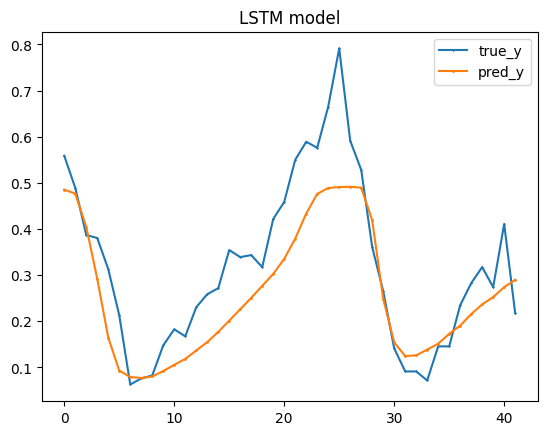

In [32]:
plt.title("LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid_passenger_count,marker="x",markersize=1,label="true_y")
plt.plot(x,preds_passenger_count,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()

In [33]:
loss = 0
for i in range(len(y_valid)):
    loss += ((preds_passenger_count[i]-y_valid_passenger_count[i])**2)**0.5
    
print("总误差是{}".format(loss))

总误差是[3.3148047]
